In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, auc, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeRegressor as dtr
from itertools import product
seed_val = 201601058
np.random.seed(seed_val)
sns.set()
font_titlesize = 18
font_axeslabelsize = 14
font_legendsize = 10

In [2]:
# Loading data
real_df = pd.read_csv('movieReplicationSet.csv')
mov_count = 400
real_df.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,NaN,NaN,3.5,NaN,0.5,NaN,0.5,1.0,NaN,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1


In [3]:
# Eliminate rows that have all nans
rows_dropped = []
cols_dropped = []
for i in range(real_df.shape[0]):
    row_nan_count = real_df.iloc[i, 1:mov_count+1].isna().sum()
    if row_nan_count == mov_count:
        rows_dropped.append(i)

# Eliminate columns that have all nans
for j in range(1, real_df.shape[1]):
    col_nan_count = real_df.iloc[:, j].isna().sum()
    if col_nan_count == real_df.shape[0]:
        cols_dropped.append(j)

if len(rows_dropped) > 0:
    df = real_df.drop(rows_dropped).reset_index(drop=True)
    real_df = real_df.drop(rows_dropped).reset_index(drop=True)
if len(cols_dropped) > 0:
    df = real_df.drop(columns = df.columns[cols_dropped])
    real_df = real_df.drop(rows_dropped).reset_index(drop=True)

    
print(f'{len(rows_dropped)} rows and {len(cols_dropped)} were dropped.')

1 rows and 0 were dropped.


In [4]:
ratings_df = df.iloc[:, :mov_count]

# Calculate column and row averages
col_avgs = ratings_df.mean(axis = 0)
row_avgs = ratings_df.mean(axis = 1)

# Replace missing values with the average of the column and row
for i in range(ratings_df.shape[0]):
    for j in range(ratings_df.shape[1]):
        if pd.isna(df.iloc[i, j]):
            # Compute the blend of the column and row means
            blend = round((col_avgs[j] + row_avgs[i]) / 2, 1)
            # Replace the missing value with the blend
            df.iloc[i, j] = blend
df.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,2.4,2.4,4.0,2.7,3.0,2.7,2.6,2.8,2.6,2.8,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,2.4,2.4,1.5,2.7,2.8,2.7,2.5,2.8,2.6,2.8,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,2.7,2.7,3.2,3.0,3.0,3.0,2.8,3.1,2.9,3.1,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,2.3,2.2,2.0,2.6,3.0,2.5,2.4,2.7,2.5,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,2.2,2.1,3.5,2.5,0.5,2.4,0.5,1.0,2.4,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1


#### 1) For each of the 400 movies, use a simple linear regression model to predict the ratings. Use the ratings of the other 399 movies in the dataset to predict the ratings of each movie (that means you’ll have to build 399 models for each of the 400 movies). For each of the 400 movies, find the movie that predicts ratings the best. Then report the average COD of those 400 simple linear regression models. Please include a histogram of these 400 COD values and a table with the 10 movies that are most easily predicted from the ratings of a single other movie and the 10 movies that are hardest to predict from the ratings of a single other movie (and their associated COD values, as well as which movie ratings are the best predictor, so this table should have 3 columns).

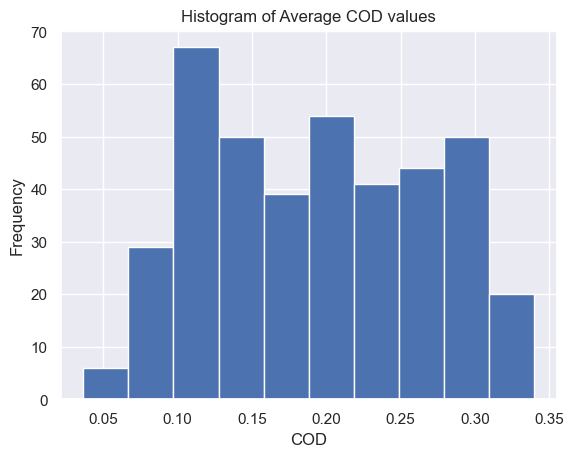

,Target movie,avg COD,best COD,Best Predictor
0,The Life of David Gale (2003),0.275091,0.556450,The King of Marvin Gardens (1972)
1,Wing Commander (1999),0.265670,0.559571,Sexy Beast (2000)
2,Django Unchained (2012),0.112930,0.234026,The Life of David Gale (2003)
3,Alien (1979),0.138351,0.327509,Aliens (1986)
4,Indiana Jones and the Last Crusade (1989),0.115277,0.372925,Indiana Jones and the Temple of Doom (1984)
5,Snatch (2000),0.215485,0.454504,Slackers (2002)
6,Rambo: First Blood Part II (1985),0.142467,0.289481,Pieces of April (2003)
7,Fargo (1996),0.141444,0.285784,The King of Marvin Gardens (1972)
8,Let the Right One In (2008),0.226720,0.436487,The King of Marvin Gardens (1972)
9,Black Swan (2010),0.058105,0.116818,Once Upon a Time in America (1984)


In [5]:
best_predictors = []
avg_cod = []
best_cod = []
for movie_idx in range(mov_count):
    # Target movie column
    y = df.iloc[:, movie_idx].values.reshape(-1, 1)
    # Create an array to store r2 for model fits for this model
    r2_vals =[]
    not_this_movie = [i for i in range(mov_count) if i != movie_idx]
    for predictor_idx in not_this_movie:
        # Predictor movie columns
        x = df.iloc[:, predictor_idx].values.reshape(-1, 1)

        # Model fitting
        model = LinearRegression()
        model.fit(x, y)

        # Model predictions
        yp = model.predict(x)
        r2_vals.append(r2_score(y, yp))
    
    max_r2_idx = np.argmax(r2_vals)
    if max_r2_idx >= movie_idx:
        max_r2_idx += 1
    best_predictors.append(df.columns[max_r2_idx])
    best_cod.append(np.max(r2_vals))
    avg_cod.append(np.mean(r2_vals))

# Plot the COD values
plt.hist(avg_cod)
plt.xlabel('COD')
plt.ylabel('Frequency')
plt.title('Histogram of Average COD values')
plt.show()

# Create a summary dataframe by combining target movies, cod_values, best_predictors and their beta values
summary_df = pd.DataFrame({'Target movie': df.columns[:mov_count], 'avg COD': avg_cod, 'best COD': best_cod, 'Best Predictor': best_predictors})
summary_df.head(10)

In [6]:
# 10 movies that are easily predicted from the ratings of single other movie
top10_df = summary_df.sort_values(by='best COD', ascending = False).set_index('Target movie').drop(columns = ['avg COD']).iloc[:10, :]
print(tabulate(top10_df, headers = 'keys', tablefmt = 'psql'))

+---------------------------+------------+---------------------------+
| Target movie              |   best COD | Best Predictor            |
|---------------------------+------------+---------------------------|
| Erik the Viking (1989)    |   0.723343 | I.Q. (1994)               |
| I.Q. (1994)               |   0.723343 | Erik the Viking (1989)    |
| The Lookout (2007)        |   0.704884 | Patton (1970)             |
| Patton (1970)             |   0.704884 | The Lookout (2007)        |
| Best Laid Plans (1999)    |   0.703987 | The Bandit (1996)         |
| The Bandit (1996)         |   0.703987 | Best Laid Plans (1999)    |
| Congo (1995)              |   0.701036 | The Straight Story (1999) |
| The Straight Story (1999) |   0.701036 | Congo (1995)              |
| Heavy Traffic (1973)      |   0.687072 | Ran (1985)                |
| Ran (1985)                |   0.687072 | Heavy Traffic (1973)      |
+---------------------------+------------+---------------------------+


In [7]:
# 10 movies that are difficult to predict from the ratings of single other movie
bottom10_df = summary_df.sort_values(by='best COD', ascending = True).set_index('Target movie').drop(columns = ['avg COD']).iloc[:10, :]
print(tabulate(bottom10_df, headers = 'keys', tablefmt = 'psql'))

+---------------------------------+------------+-----------------------------------------------------------+
| Target movie                    |   best COD | Best Predictor                                            |
|---------------------------------+------------+-----------------------------------------------------------|
| Avatar (2009)                   |  0.0791126 | Indiana Jones and the Kingdom of the Crystal Skull (2008) |
| Interstellar (2014)             |  0.108968  | Torque (2004)                                             |
| Black Swan (2010)               |  0.116818  | Once Upon a Time in America (1984)                        |
| Clueless (1995)                 |  0.138304  | Love Story (1970)                                         |
| The Cabin in the Woods (2012)   |  0.142478  | The Evil Dead (1981)                                      |
| La La Land (2016)               |  0.146454  | The Lookout (2007)                                        |
| Titanic (1997)   

#### 2) For the 10 movies that are best and least well predicted from the ratings of a single other movie (so 20 in total), build multiple regression models that include gender identity (column 475), sibship status (column 476) and social viewing preferences (column 477) as additional predictors (in addition to the best predicting movie from question 1). Comment on how R^2 has changed relative to the answers in question 1. Please include a figure with a scatterplot where the old COD (for the simple linear regression models from the previous question) is on the x-axis and the new R^2 (for the new multiple regression models) is on the y-axis.

In [8]:
additional_cols = np.asarray(['Gender identity (1 = female; 2 = male; 3 = self-described)',
        'Are you an only child? (1: Yes; 0: No; -1: Did not respond)',
        'Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)'])

q2_df = df.copy(deep=True)
q2_df.rename(columns = {'Gender identity (1 = female; 2 = male; 3 = self-described)': 'Gender',
            'Are you an only child? (1: Yes; 0: No; -1: Did not respond)': 'sibship',
            'Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)': 'socialviewing'}, inplace = True)

# Eliminate rows where Gender is not Self-described, or sibship and social viewing is not reported or if any of these entries are
q2_df = q2_df.drop(q2_df[(q2_df['Gender'] == 3) | (q2_df['sibship'] == -1) | (q2_df['socialviewing'] == -1)].index).dropna(subset = ['Gender'], axis=0)
q2_df.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender,sibship,socialviewing
0,2.4,2.4,4.0,2.7,3.0,2.7,2.6,2.8,2.6,2.8,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,2.4,2.4,1.5,2.7,2.8,2.7,2.5,2.8,2.6,2.8,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,2.7,2.7,3.2,3.0,3.0,3.0,2.8,3.1,2.9,3.1,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,2.3,2.2,2.0,2.6,3.0,2.5,2.4,2.7,2.5,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,2.2,2.1,3.5,2.5,0.5,2.4,0.5,1.0,2.4,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1


In [9]:
# One hot encode gender for regression
gender_dummy = pd.get_dummies(q2_df['Gender'], prefix = 'gender', drop_first = True)
q2_df = q2_df.drop('Gender', axis = 1)

q2_df = q2_df.join(gender_dummy)
q2_df.head()

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,sibship,socialviewing,gender_2.0
0,2.4,2.4,4.0,2.7,3.0,2.7,2.6,2.8,2.6,2.8,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,0,1,0
1,2.4,2.4,1.5,2.7,2.8,2.7,2.5,2.8,2.6,2.8,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,0,0,0
2,2.7,2.7,3.2,3.0,3.0,3.0,2.8,3.1,2.9,3.1,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1,0,0
3,2.3,2.2,2.0,2.6,3.0,2.5,2.4,2.7,2.5,4.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,0,1,0
4,2.2,2.1,3.5,2.5,0.5,2.4,0.5,1.0,2.4,0.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1,1,0


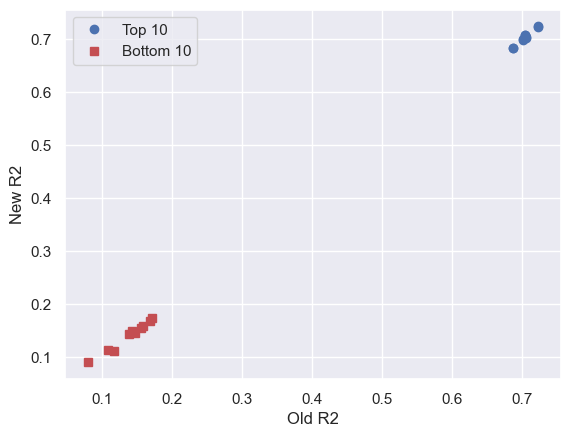

In [10]:
top10_r2 = top10_df['best COD'][0:10].to_numpy()
bottom10_r2 = bottom10_df['best COD'][0:10].to_numpy()
top10_predictor = top10_df['Best Predictor'][0:10].to_numpy()
bottom10_predictor = bottom10_df['Best Predictor'][0:10].to_numpy()
top10_movies = top10_df.index[0:10].to_numpy()
bottom10_movies = bottom10_df.index[0:10].to_numpy()

concat_r2 = np.concatenate((top10_r2, bottom10_r2))
concat_predictor = np.concatenate((top10_predictor, bottom10_predictor))
concat_movies = np.concatenate((top10_movies, bottom10_movies))

mlg_cod = []
for movie_idx in range(20):
    target_name = concat_movies[movie_idx]
    # Target movie column
    y = q2_df[target_name].values.reshape(-1, 1)
    predictors = [concat_predictor[movie_idx], 'sibship', 'socialviewing', 'gender_2.0']
    X = q2_df[predictors]
    model = LinearRegression()
    model.fit(X, y)
      
    # Model predictions
    yp = model.predict(X)
    mlg_cod.append(r2_score(y, yp))

# Plot the COD values
plt.plot(top10_r2, mlg_cod[0:10], 'bo', label = 'Top 10')
plt.plot(bottom10_r2, mlg_cod[10:20], 'rs', label = 'Bottom 10')
plt.xlabel('Old R2')
plt.ylabel('New R2')
plt.legend()
plt.show()

In [11]:
q2_result_df = pd.DataFrame(index = concat_movies)
q2_result_df['Old CODs'] = concat_r2
q2_result_df['New CODs'] = mlg_cod
q2_result_df.head(20)

,Old CODs,New CODs
Erik the Viking (1989),0.723343,0.723456
I.Q. (1994),0.723343,0.722357
The Lookout (2007),0.704884,0.703801
Patton (1970),0.704884,0.702488
Best Laid Plans (1999),0.703987,0.707138
The Bandit (1996),0.703987,0.707293
Congo (1995),0.701036,0.698630
The Straight Story (1999),0.701036,0.699555
Heavy Traffic (1973),0.687072,0.683754
Ran (1985),0.687072,0.683491


#### 3) Pick 30 movies in the middle of the COD range, as identified by question 1 (that were not used in question 2). Now build a regularized regression model with the ratings from 10 other movies (picked randomly, or deliberately by you) as an input. Please use ridge regression, and make sure to do suitable hyperparameter tuning. Also make sure to report the RMSE for each of these 30 movies in a table, after doing an 80/20 train/test split. Comment on the hyperparameters you use and betas you find by doing so.

In [12]:
# Look at the middle 30 movies based on the COD range
middle_df = summary_df.sort_values(by='best COD', ascending = True).set_index('Target movie').iloc[mov_count//2 - 15:mov_count//2 + 15, :]
middle_df.head(10)

,avg COD,best COD,Best Predictor
Target movie,,,
Twister (1996),0.224547,0.411274,Sexy Beast (2000)
Aliens (1986),0.196537,0.412504,Miller's Crossing (1990)
Austin Powers in Goldmember (2002),0.153687,0.412922,Austin Powers: The Spy Who Shagged Me (1999)
Austin Powers: The Spy Who Shagged Me (1999),0.162034,0.412922,Austin Powers in Goldmember (2002)
Gone in Sixty Seconds (2000),0.199683,0.413679,Change of Habit (1969)
28 Days Later (2002),0.206534,0.414014,Miller's Crossing (1990)
The Big Lebowski (1998),0.209929,0.414669,Escape from LA (1996)
Blues Brothers 2000 (1998),0.201530,0.416080,The 51st State (2001)
Goodfellas (1990),0.214517,0.416278,The Sting (1973)


In [13]:
q3_df = df[middle_df.index]
X = df[top10_df.index]
idxs = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(idxs, test_size = 0.2, random_state = seed_val)
X_train = X.iloc[train_idx, :]
X_test = X.iloc[test_idx, :]

In [14]:
alphas_to_try_first_pass = np.linspace(0, 1000, 100)
params = {'alpha': alphas_to_try_first_pass}
best_alpha = []
for movie_idx in range(30):
    # Target movie column
    y = q3_df.iloc[:, movie_idx].values.reshape(-1, 1)
    y_train = y[train_idx, :]
    clf = GridSearchCV(Ridge(), params, scoring = 'r2', n_jobs=-1, cv = 10).fit(X_train, y_train)
    best_alpha.append(clf.best_params_['alpha'])
print(np.round(np.asarray(best_alpha), 3))

[ 80.808  80.808  30.303  50.505 141.414  70.707  30.303 151.515  50.505
 101.01   50.505  30.303  40.404  60.606  40.404  10.101  50.505  90.909
  80.808 121.212  50.505  80.808  50.505  30.303 232.323  50.505  60.606
 181.818  80.808  30.303]


In [15]:
alphas_to_try_second_pass = np.linspace(25, 250, 200)
params = {'alpha': alphas_to_try_second_pass}
best_alpha = []
for movie_idx in range(30):
    # Target movie column
    y = q3_df.iloc[:, movie_idx].values.reshape(-1, 1)
    y_train = y[train_idx, :]
    clf = GridSearchCV(Ridge(), params, scoring = 'r2', n_jobs = -1, cv = 10).fit(X_train, y_train)
    best_alpha.append(clf.best_params_['alpha'])
print(np.round(np.asarray(best_alpha), 3))

[ 81.533  77.01   27.261  45.352 141.457  65.704  29.523 150.503  51.005
 103.015  54.397  30.653  41.96   65.704  37.437  25.     55.528  95.101
  83.794 121.106  51.005  84.925  47.613  35.176 233.04   54.397  61.181
 179.899  83.794  28.392]


In [16]:
RMSE_train = np.zeros((30,))
RMSE_test = np.zeros((30,))
betas = np.zeros((30, 10))
intercepts = np.zeros((30,))

for movie_idx in range(30):
    # Target movie column
    y = q3_df.iloc[:, movie_idx].values.reshape(-1, 1)
    y_train = y[train_idx, :]
    y_test = y[test_idx, :]

    # Initialize and fit model to train data
    model = Ridge(alpha = best_alpha[movie_idx], random_state = seed_val)
    model.fit(X_train, y_train)

    # Compute betas
    betas[movie_idx, :] = np.round(model.coef_[0], 2)
    intercepts[movie_idx] = np.round(model.intercept_, 2)

    # Generate train and test predictions
    yp_train = model.predict(X_train)
    yp_test = model.predict(X_test)

    # Compute RMSE for train and test
    RMSE_train[movie_idx] = mean_squared_error(y_train, yp_train, squared = False)
    RMSE_test[movie_idx] = mean_squared_error(y_test, yp_test, squared = False)

In [17]:
q3_summary_df = pd.DataFrame(index = q3_df.columns, columns = range(0, 10))
for ii in range(q3_summary_df.shape[0]):
    q3_summary_df.iloc[ii, :] = betas[ii, :]
q3_summary_df['Intercept'] = intercepts
q3_summary_df['alpha'] = np.round(best_alpha, 2)
q3_summary_df['RMSE train'] = np.round(RMSE_train, 2)
q3_summary_df['RMSE test'] = np.round(RMSE_test, 2)

q3_summary_df.head(30)

,0,1,2,3,4,5,6,7,8,9,Intercept,alpha,RMSE train,RMSE test
Twister (1996),0.06,0.08,0.13,0.1,0.13,0.09,0.08,0.05,0.09,0.1,0.32,81.53,0.32,0.39
Aliens (1986),0.1,0.11,0.13,0.18,0.07,0.09,0.06,0.11,0.08,0.1,0.20,77.01,0.35,0.47
Austin Powers in Goldmember (2002),0.1,0.05,0.19,0.26,0.06,0.1,-0.01,0.04,0.19,0.16,-0.28,27.26,0.51,0.60
Austin Powers: The Spy Who Shagged Me (1999),0.12,0.23,0.1,0.2,0.17,0.11,0.07,0.12,0.11,-0.03,-0.35,45.35,0.56,0.47
Gone in Sixty Seconds (2000),0.04,0.02,0.12,0.1,0.1,0.13,0.06,0.05,0.06,0.05,0.69,141.46,0.33,0.37
28 Days Later (2002),0.09,0.0,0.09,0.18,0.07,0.14,0.05,0.08,0.12,0.1,0.41,65.70,0.35,0.37
The Big Lebowski (1998),0.07,0.02,0.17,0.2,0.2,0.01,-0.05,0.04,0.15,0.2,0.37,29.52,0.36,0.29
Blues Brothers 2000 (1998),0.08,0.06,0.09,0.05,0.06,0.12,0.07,0.09,0.07,0.09,0.67,150.50,0.36,0.37
Goodfellas (1990),0.12,0.17,0.04,0.18,0.04,0.08,0.1,0.04,0.15,0.09,0.44,51.01,0.34,0.38
Dances with Wolves (1990),0.08,0.1,0.07,0.08,0.09,0.1,0.04,0.07,0.12,0.08,0.59,103.02,0.34,0.42


#### 4) Repeat question 3) with LASSO regression. Again, make sure to comment on the hyperparameters you use and betas you find by doing so. 

In [18]:
q4_df = df[middle_df.index]
X = df[top10_df.index]
idxs = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(idxs, test_size = 0.2, random_state = seed_val)
X_train = X.iloc[train_idx, :]
X_test = X.iloc[test_idx, :]

In [19]:
alphas_to_try_first_pass = np.linspace(1e-14, 1, 100)
params = {'alpha': alphas_to_try_first_pass}
best_alpha = []
for movie_idx in range(30):
    # Target movie column
    y = q4_df.iloc[:, movie_idx].values.reshape(-1, 1)
    y_train = y[train_idx, :]
    clf = GridSearchCV(Lasso(), params, scoring = 'r2', n_jobs=-1, cv = 10).fit(X_train, y_train)
    best_alpha.append(clf.best_params_['alpha'])
low_idx = np.where(np.asarray(best_alpha) < 1e-13)[0]
print(np.asarray(best_alpha))

[1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 2.02020202e-02 1.00000000e-14 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.00000000e-14
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 1.01010101e-02 1.01010101e-02 1.01010101e-02 1.01010101e-02
 2.02020202e-02 1.01010101e-02 1.01010101e-02 2.02020202e-02
 1.01010101e-02 1.01010101e-02]


In [20]:
alphas_to_try_second_pass = np.linspace(1e-3, 1e-1, 200)
params = {'alpha': alphas_to_try_second_pass}
best_alpha = []
for movie_idx in range(30):
    # Target movie column
    y = q4_df.iloc[:, movie_idx].values.reshape(-1, 1)
    y_train = y[train_idx, :]
    clf = GridSearchCV(Lasso(), params, scoring = 'r2', n_jobs=-1, cv = 10).fit(X_train, y_train)
    best_alpha.append(clf.best_params_['alpha'])
best_alpha = np.asarray(best_alpha)
best_alpha[low_idx] = 1e-14
print(best_alpha)

[5.47738693e-03 6.96984925e-03 6.96984925e-03 9.45728643e-03
 1.54271357e-02 1.00000000e-14 5.47738693e-03 9.95477387e-03
 5.47738693e-03 9.45728643e-03 5.47738693e-03 4.48241206e-03
 2.49246231e-03 6.47236181e-03 1.49748744e-03 1.00000000e-14
 1.34371859e-02 1.34371859e-02 4.48241206e-03 8.46231156e-03
 5.97487437e-03 6.96984925e-03 1.49748744e-03 4.97989950e-03
 2.13969849e-02 5.47738693e-03 4.97989950e-03 1.59246231e-02
 4.97989950e-03 1.99497487e-03]


In [21]:
RMSE_train = np.zeros((30,))
RMSE_test = np.zeros((30,))
betas = np.zeros((30, 10))
intercepts = np.zeros((30,))

for movie_idx in range(30):
    # Target movie column
    y = q4_df.iloc[:, movie_idx].values.reshape(-1, 1)
    y_train = y[train_idx, :]
    y_test = y[test_idx, :]
    
    # Initialize and fit model to train data
    model = Lasso(alpha = best_alpha[movie_idx], random_state = seed_val)
    model.fit(X_train, y_train)
    # Compute betas
    betas[movie_idx, :] = np.round(model.coef_, 2)
    intercepts[movie_idx] = np.round(model.intercept_, 2)

    # Generate train and test predictions
    yp_train = model.predict(X_train)
    yp_test = model.predict(X_test)
    
    # Compute RMSE for train and test
    RMSE_train[movie_idx] = mean_squared_error(y_train, yp_train, squared = False)
    RMSE_test[movie_idx] = mean_squared_error(y_test, yp_test, squared = False)

In [22]:
q4_summary_df = pd.DataFrame(index = q4_df.columns, columns = range(0, 10))
for ii in range(q4_summary_df.shape[0]):
    q4_summary_df.iloc[ii, :] = betas[ii, :]
q4_summary_df['Intercept'] = intercepts
q4_summary_df['alpha'] = best_alpha
q4_summary_df['RMSE train'] = np.round(RMSE_train, 2)
q4_summary_df['RMSE test'] = np.round(RMSE_test, 2)

q4_summary_df.head(30)

,0,1,2,3,4,5,6,7,8,9,Intercept,alpha,RMSE train,RMSE test
Twister (1996),0.0,0.09,0.28,0.06,0.26,0.02,0.09,0.0,0.06,0.1,0.22,5.477387e-03,0.32,0.39
Aliens (1986),0.09,0.13,0.12,0.4,0.02,0.04,0.0,0.16,0.01,0.06,0.12,6.969849e-03,0.35,0.49
Austin Powers in Goldmember (2002),0.1,0.0,0.18,0.37,0.0,0.09,0.0,0.0,0.29,0.12,-0.23,6.969849e-03,0.51,0.61
Austin Powers: The Spy Who Shagged Me (1999),0.0,0.42,0.0,0.35,0.27,0.03,0.0,0.12,0.0,0.0,-0.29,9.457286e-03,0.56,0.46
Gone in Sixty Seconds (2000),0.0,0.0,0.17,0.14,0.04,0.39,0.0,0.0,0.0,0.0,0.66,1.542714e-02,0.32,0.39
28 Days Later (2002),0.15,-0.29,-0.19,0.52,0.02,0.36,-0.09,0.11,0.38,0.0,0.20,1.000000e-14,0.34,0.43
The Big Lebowski (1998),0.0,0.0,0.12,0.27,0.27,0.0,-0.0,0.0,0.1,0.24,0.39,5.477387e-03,0.36,0.29
Blues Brothers 2000 (1998),0.11,0.0,0.08,0.0,0.0,0.38,0.0,0.08,0.0,0.18,0.52,9.954774e-03,0.36,0.38
Goodfellas (1990),0.09,0.26,0.0,0.32,0.0,0.03,0.05,0.0,0.27,0.01,0.40,5.477387e-03,0.34,0.37
Dances with Wolves (1990),0.02,0.11,0.0,0.07,0.05,0.21,0.0,0.0,0.34,0.03,0.57,9.457286e-03,0.33,0.44


#### 5) Compute the average movie enjoyment for each user (using only real, non-imputed data). Use these averages as the predictor variable X in a logistic regression model. Sort the movies order of increasing rating (also using only real, non-imputed data). Now pick the 4 movies in the middle of the score range as your target movie. For each of them, do a median split (now using the imputed data) of ratings to code movies above the median rating with the Y label 1 (= enjoyed) and movies below the median with the label 0 (= not enjoyed). For each of these movies, build a logistic regression model (using X to predict Y), show figures with the outcomes and report the betas as well as the AUC values. Comment on the quality of your models. Make sure to use cross-validation methods to avoid overfitting.

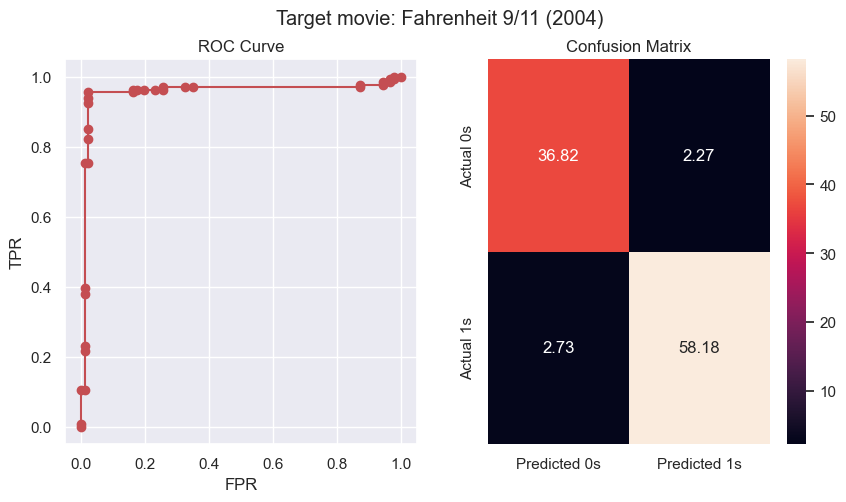

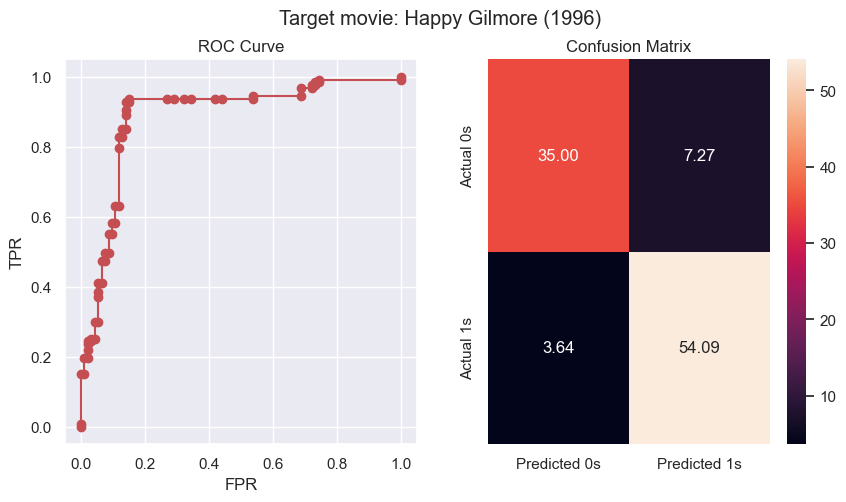

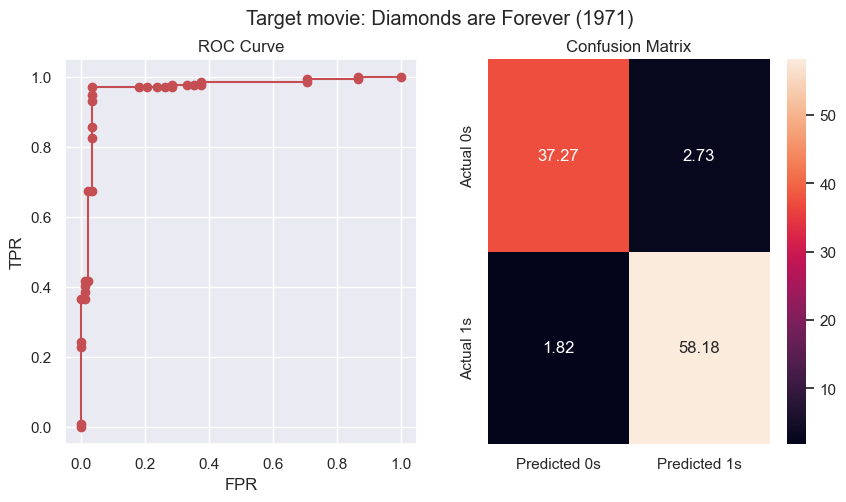

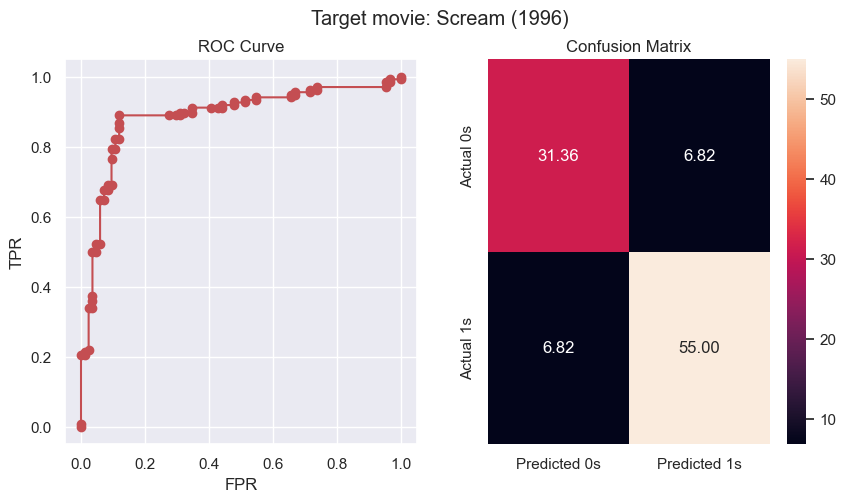

In [23]:
# Predictors
X = real_df.iloc[:, :mov_count].mean(axis = 1).values.reshape(-1, 1) # average movie enjoyment for each user

# Target
avg_movie_rating = real_df.iloc[:, :mov_count].mean(axis = 0).sort_values(ascending = True)
predictor_movies = avg_movie_rating[len(avg_movie_rating)//2 - 2:len(avg_movie_rating)//2 + 2].index
y_rating = df[predictor_movies]

auc_score = []
betas = []
intercepts = []

for mov in predictor_movies:
    # Median-split target variable   
    y = (y_rating[mov]>=y_rating[mov].median()).replace({True:1, False:0})
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state=seed_val)
    
    # Logistic Regression Model
    model = LogisticRegressionCV(random_state = seed_val, cv = 10)
    model.fit(X_train, y_train)
    betas.append(model.coef_[0][0])
    intercepts.append(model.intercept_[0])

    # Evaluate the model
    p_pred = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    conf_m = confusion_matrix(y_test, y_pred, normalize = 'all')
    fpr, tpr, _ = roc_curve(y_test, p_pred[:, 1])
    auc_score.append(auc(fpr, tpr))
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    plt.suptitle(f'Target movie: {mov}')
    ax[0].plot(fpr, tpr, 'ro-')
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')
    ax[0].set_title('ROC Curve')

    ax[1] = sns.heatmap(conf_m*100, annot = True, fmt = '.2f')
    ax[1].xaxis.set(ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax[1].yaxis.set(ticklabels=('Actual 0s', 'Actual 1s'))
    ax[1].set_title('Confusion Matrix')
    plt.show()

In [24]:
q5_df = pd.DataFrame(index = predictor_movies)
q5_df['AUC test'] = auc_score
q5_df['beta'] = betas
q5_df['intercept'] = intercepts
q5_df

,AUC test,beta,intercept
Fahrenheit 9/11 (2004),0.956612,10.514312,-30.458468
Happy Gilmore (1996),0.887393,5.865999,-16.899860
Diamonds are Forever (1971),0.966598,8.070634,-23.324315
Scream (1996),0.887824,5.047525,-14.479993
